In [1]:
import pandas as pd
from rdkit.Chem import AllChem as Chem
from rdkit.Chem import Draw
from rdkit.Chem.Scaffolds import MurckoScaffold

df = pd.read_csv('manual-annot.tsv', delimiter='\t')
lib = pd.read_csv('../data/lib/layouts.csv',index_col=0)

lib_mols = [Chem.MolFromSmiles(i) for i in lib['SMILES']]
lib_scaffs = [MurckoScaffold.GetScaffoldForMol(i) for i in lib_mols]
lib_scaff_smiles = [MurckoScaffold.MurckoScaffoldSmiles(i) for i in lib['SMILES']]
print(f"{len(set(lib_scaff_smiles))} unique scaffolds out of {len(lib_mols)}")

616 unique scaffolds out of 978


/home/u0/miniconda3/envs/sxfst/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
100%|███████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 219.51it/s]


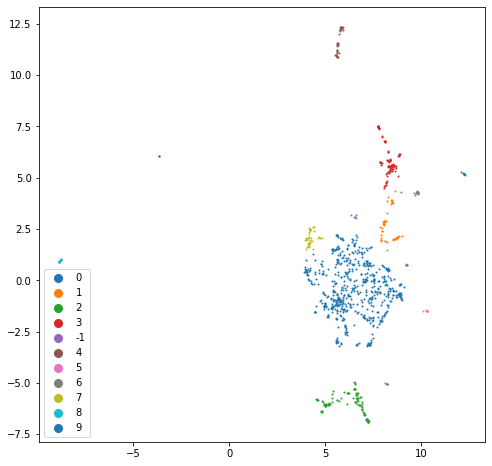

CPU times: user 25.6 s, sys: 176 ms, total: 25.8 s
Wall time: 18.8 s


In [2]:
%%time
from tqdm import tqdm
import numpy as np
from umap import UMAP
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN 

fps = np.array([Chem.RDKFingerprint(i) for i in lib_mols])

um = UMAP(metric='manhattan')
xy = um.fit_transform(fps)

dbscan = DBSCAN(eps=0.5,
                min_samples=8,
                n_jobs=-1)
clusters = dbscan.fit_predict(xy)

xyz = pd.DataFrame(xy, columns=list('xy'))
xyz['z'] = clusters

plt.figure(figsize=(8,8))
for i in tqdm(xyz['z'].unique()):
    cl = xyz.loc[xyz['z'] == i, :]
    plt.scatter(cl['x'], 
                cl['y'],
                s=1,
                label=i,
               )
plt.legend(markerscale=8,
           loc='lower left')
plt.show()

In [3]:
from PIL import Image
from io import BytesIO

lib['Cluster'] = clusters
lib['Scaffold'] = lib_scaff_smiles

for i in tqdm(lib['Cluster'].unique()):
    c = lib.loc[lib['Cluster']==i,:]
    if len(c) < 100:
        fig, ax = plt.subplots(len(c),2,
                               figsize=(6,len(c)*3),
                              )
        for ax_row, j, k, l in zip(ax, 
                                   c['SMILES'], 
                                   c['Scaffold'],
                                   c['Item Name']):
            im1 = Draw.MolToImage(Chem.MolFromSmiles(j))
            im2 = Draw.MolToImage(Chem.MolFromSmiles(k))
            ax_row[0].imshow(im1)
            ax_row[1].imshow(im2)
            ax_row[0].axis('off')
            ax_row[1].axis('off')
            ax_row[0].set_title(l)
            ax_row[1].set_title(f'{l} Scaffold')
        fig.suptitle(f'Cluster {i}')
        plt.tight_layout()
        #plt.show()
        plt.close()

100%|████████████████████████████████████████████████████████████████████████████████| 11/11 [00:20<00:00,  1.83s/it]


In [4]:
%%time
if not os.path.exists('img/screen'):
    os.mkdir('img/screen')

df_ = df.copy()[['chemid','smiles']].drop_duplicates()
df_['Scaffold'] = [MurckoScaffold.MurckoScaffoldSmiles(i) for i in df_['smiles']]

cn_in = dict(zip(lib['CatalogNumber'], lib['Item Name']))
df_['Item Name'] = [cn_in[i] for i in df_['chemid']]

for i, j, k, l in tqdm(zip(df_['chemid'],
                           df_['smiles'], 
                           df_['Scaffold'],
                           df_['Item Name'],
                          ),
                       total=len(df_)):
    im1 = Draw.MolToImage(Chem.MolFromSmiles(j))
    im2 = Draw.MolToImage(Chem.MolFromSmiles(k))
    plt.figure(figsize=(6,6))
    plt.imshow(im1)
    plt.axis('off')
    plt.title(l)
    plt.savefig(f'img/screen/hits-{i}.png')
    plt.close()
    
    plt.figure(figsize=(6,6))
    plt.imshow(im2)
    plt.axis('off')
    plt.title(l)
    plt.savefig(f'img/screen/hits-{i}-scaffold.png')
    plt.close()


NameError: name 'os' is not defined

In [5]:
#%%time

hits = df.loc[df['hit'], :].copy()
hits['Scaffold'] = [MurckoScaffold.MurckoScaffoldSmiles(i) for i in hits['smiles']]

cn_in = dict(zip(lib['CatalogNumber'], lib['Item Name']))
hits['Item Name'] = [cn_in[i] for i in hits['chemid']]

#for i, j, k, l in tqdm(zip(hits['chemid'],
#                           hits['smiles'], 
#                           hits['Scaffold'],
#                           hits['Item Name'],
#                          ),
#                       total=len(hits)):
#    im1 = Draw.MolToImage(Chem.MolFromSmiles(j))
#    im2 = Draw.MolToImage(Chem.MolFromSmiles(k))
#    plt.figure(figsize=(6,6))
#    plt.imshow(im1)
#    plt.axis('off')
#    plt.title(l)
#    plt.savefig(f'img/hits-{i}.png')
#    plt.close()
#    
#    plt.figure(figsize=(6,6))
#    plt.imshow(im2)
#    plt.axis('off')
#    plt.title(l)
#    plt.savefig(f'img/hits-{i}-scaffold.png')
#    plt.close()

In [6]:
hits['fig'] = [f'![](img/screen/hits-{i}.png)' for i in hits['chemid']]
hits['fig-scaffold'] = [f'![](img/screen/hits-{i}-scaffold.png)' for i in hits['chemid']]
hits_ = hits[['experiment', 'protein',  'chemid',  'Item Name', 'fig', 'fig-scaffold']]
#print(hits_.to_markdown(index=False))

In [7]:
%%time

hits = df.loc[df['hit'], :].copy()
hits['Scaffold'] = [MurckoScaffold.MurckoScaffoldSmiles(i) for i in hits['smiles']]

cn_in = dict(zip(lib['CatalogNumber'], lib['Item Name']))
hits['Item Name'] = [cn_in[i] for i in hits['chemid']]

fig, ax = plt.subplots(len(hits),2,
                       figsize=(6,len(hits)*3),
                      )
for ax_row, j, k, l in tqdm(zip(ax, 
                           hits['smiles'], 
                           hits['Scaffold'],
                           hits['Item Name']),
                            total=len(hits)):
    im1 = Draw.MolToImage(Chem.MolFromSmiles(j))
    im2 = Draw.MolToImage(Chem.MolFromSmiles(k))
    ax_row[0].imshow(im1)
    ax_row[1].imshow(im2)
    ax_row[0].axis('off')
    ax_row[1].axis('off')
    ax_row[0].set_title(l)
    ax_row[1].set_title(f'{l} Scaffold')
plt.tight_layout()
plt.savefig('img/hits-scaffolds.png')
#plt.show()
plt.close()

100%|██████████████████████████████████████████████████████████████████████████████| 149/149 [00:03<00:00, 41.58it/s]


CPU times: user 18.1 s, sys: 252 ms, total: 18.3 s
Wall time: 18.3 s


In [8]:
kd_data = pd.read_csv('kds.csv')
kd_data.head()

,cpd,protein,km,vmax,rsq
0,S1005,BM3 Heme 1YQO,372.600347,0.952343,-0.690709
1,S1021,BM3 Heme 1YQO,510.863319,1.171369,0.348476
2,S1028,BM3 Heme 1YQO,262.581079,0.666770,-0.761200
3,S1039,BM3 Heme 1YQO,55.131883,0.351526,-7.618962
4,S1046,BM3 Heme 1YQO,1333.928517,1.993043,0.228025


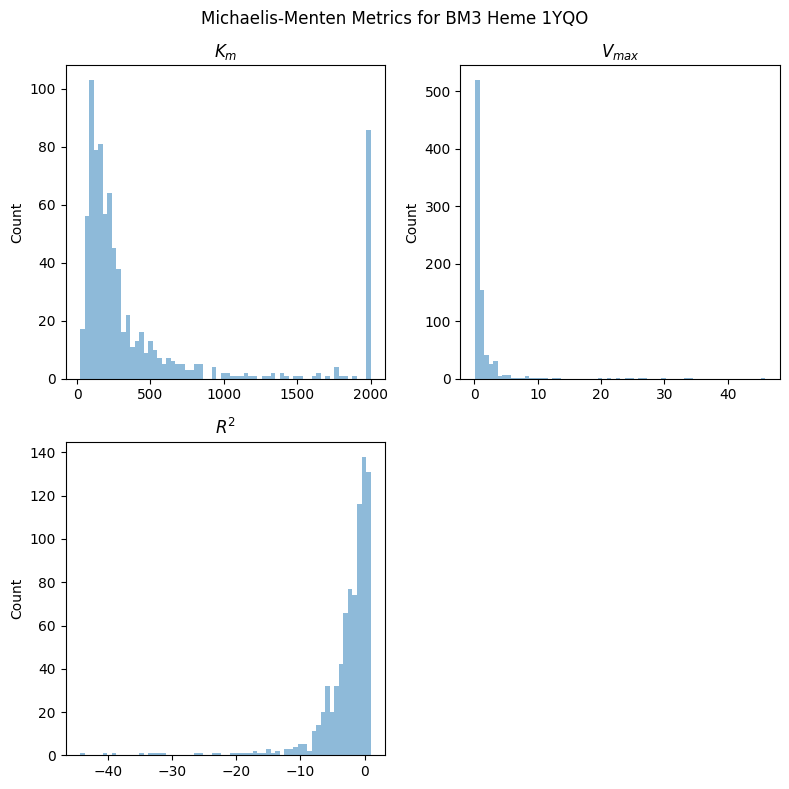

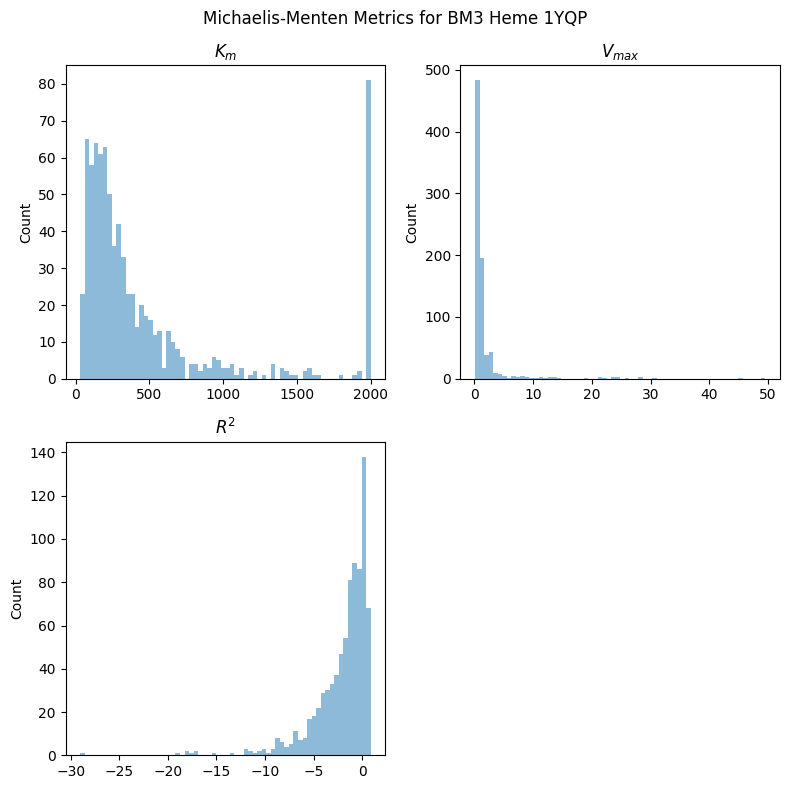

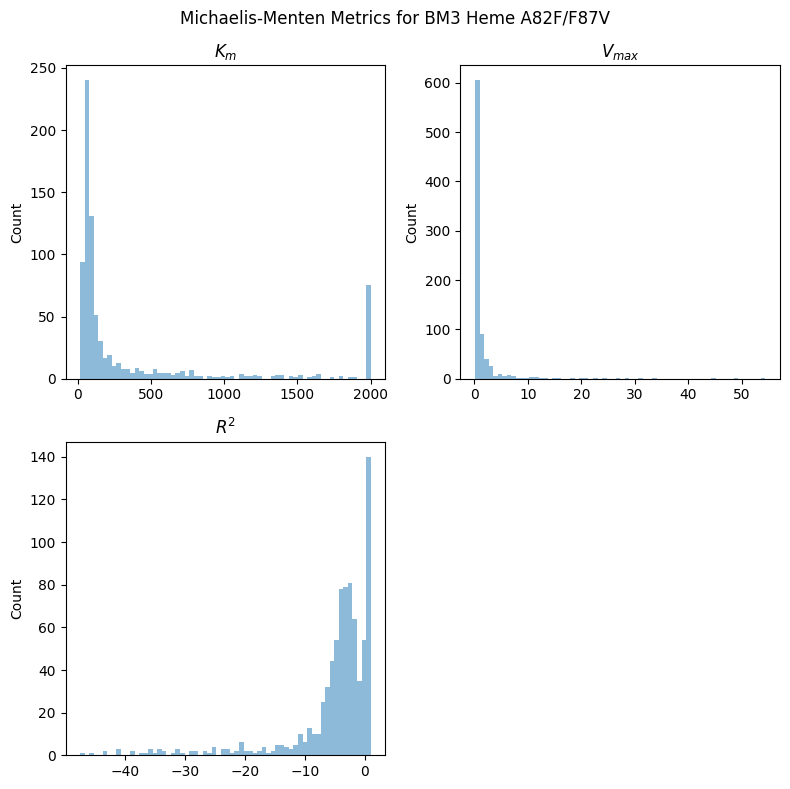

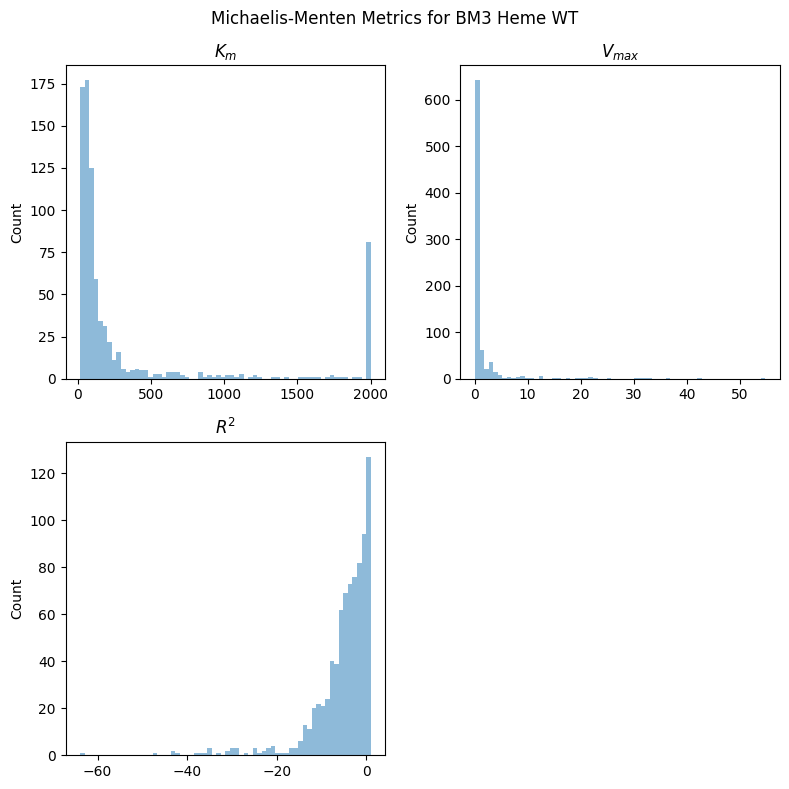

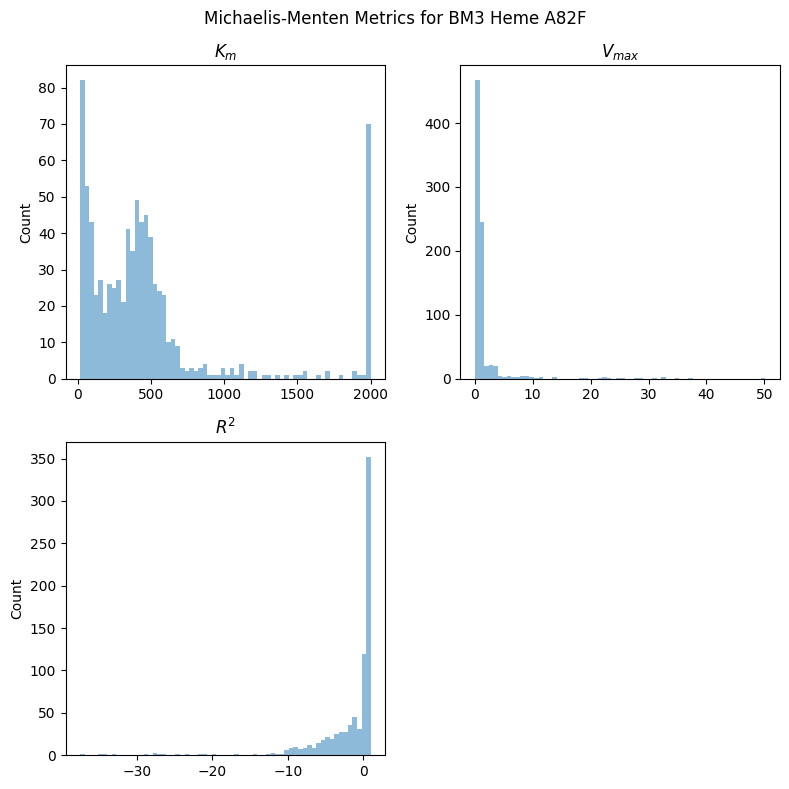

In [9]:
#plt.style.use('dark_background')
plt.style.use('default')
for i in kd_data['protein'].unique():
    chunk = kd_data.loc[kd_data['protein']==i,:]
    fig, ax = plt.subplots(2,2, figsize=(8,8))
    for j,k,l in zip(ax.flatten(), 
                     ['km','vmax','rsq'],
                     ['$K_m$', '$V_{max}$', '$R^2$']):
        j.hist(chunk[k],
               bins=64,
               alpha=0.5,
              )
        j.set_title(l)
        j.set_ylabel('Count')
    ax[1,1].axis('off')
    fig.suptitle(f'Michaelis-Menten Metrics for {i}')
    plt.tight_layout()
    plt.savefig(f"img/{i.replace('/','-').replace(' ','-')}-mm-hist.png") 
    plt.show()

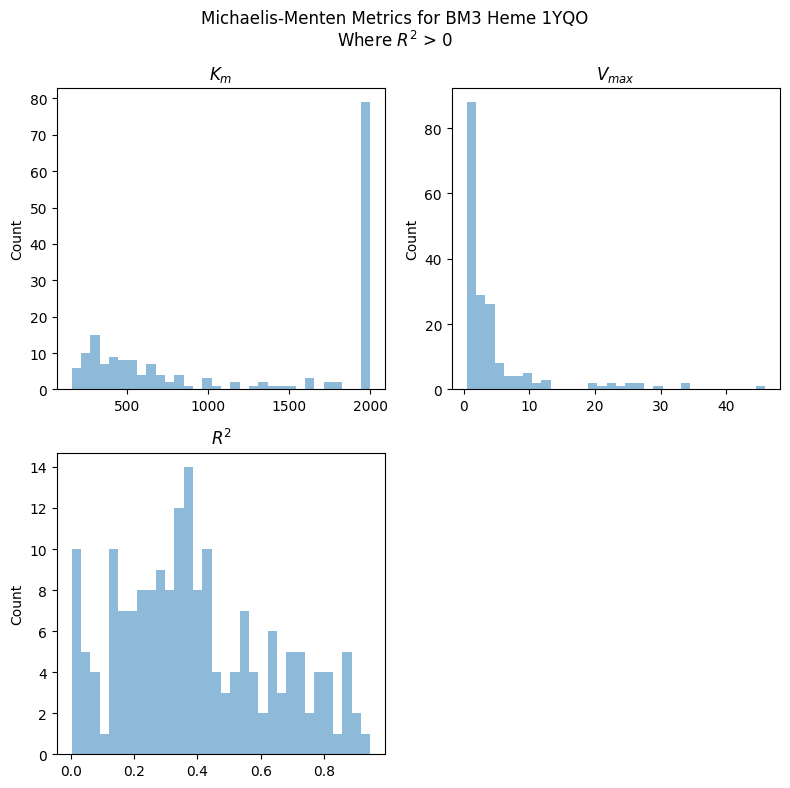

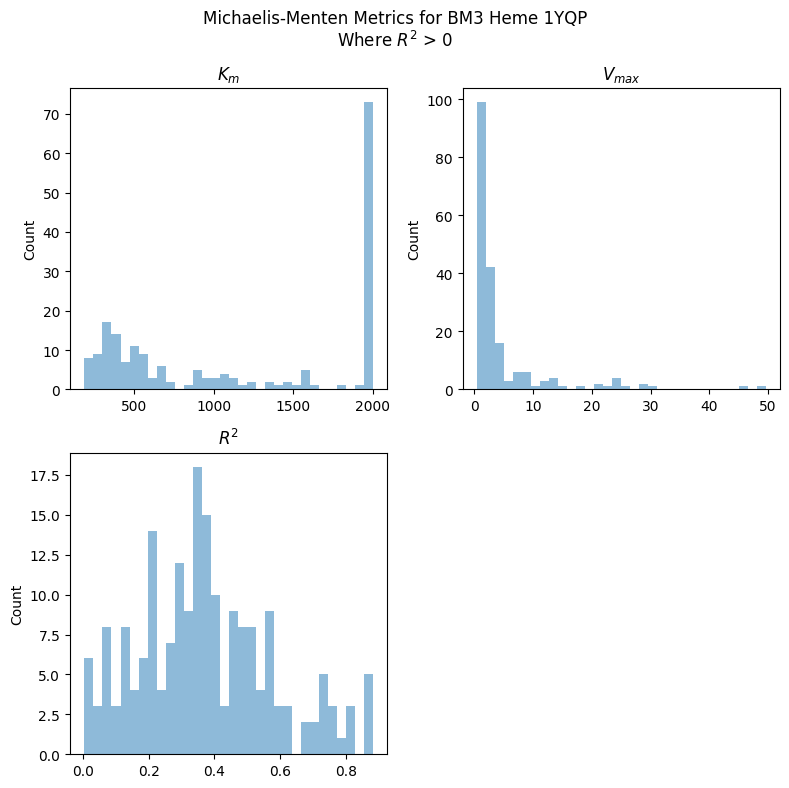

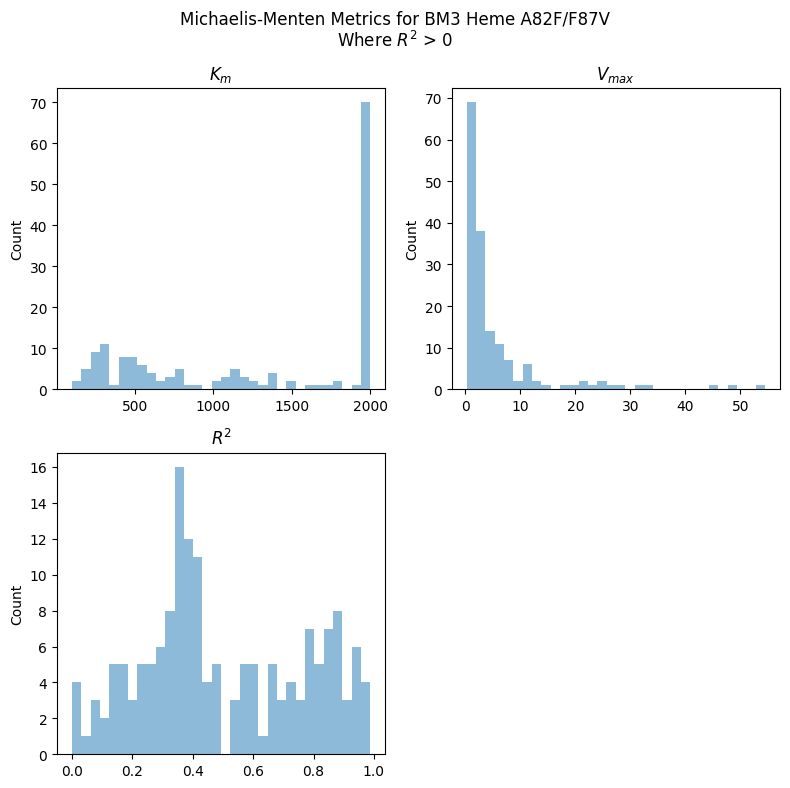

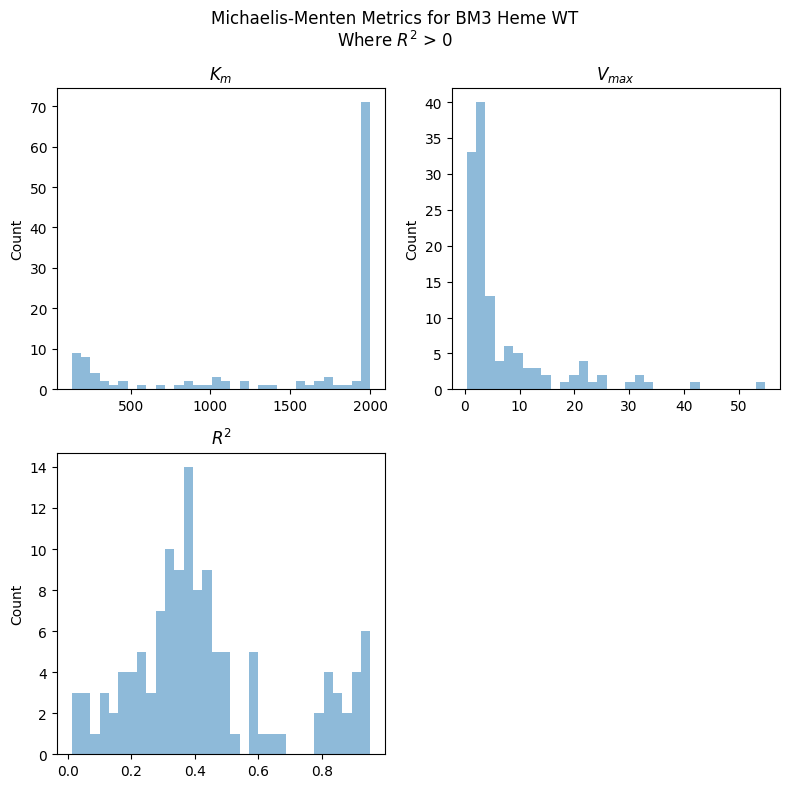

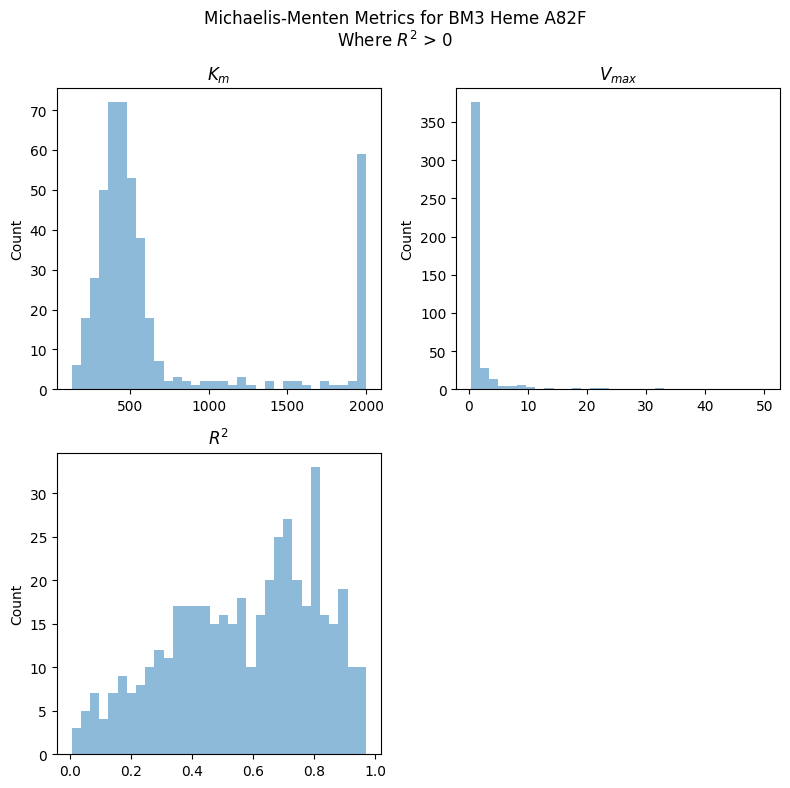

In [10]:
kd_data_ = kd_data.loc[kd_data['rsq']>0,:]
for i in kd_data['protein'].unique():
    chunk = kd_data_.loc[kd_data_['protein']==i,:]
    fig, ax = plt.subplots(2,2, figsize=(8,8))
    for j,k,l in zip(ax.flatten(), 
                     ['km','vmax','rsq'],
                     ['$K_m$', '$V_{max}$', '$R^2$']):
        j.hist(chunk[k],
               bins=32,
               alpha=0.5,
              )
        j.set_title(l)
        j.set_ylabel('Count')
    ax[1,1].axis('off')
    fig.suptitle(f'Michaelis-Menten Metrics for {i}\nWhere $R^2$ > 0')
    plt.tight_layout()
    plt.savefig(f"img/{i.replace('/','-').replace(' ','-')}-mm-hist-gt0.png") 
    plt.show()

<Figure size 800x800 with 0 Axes>

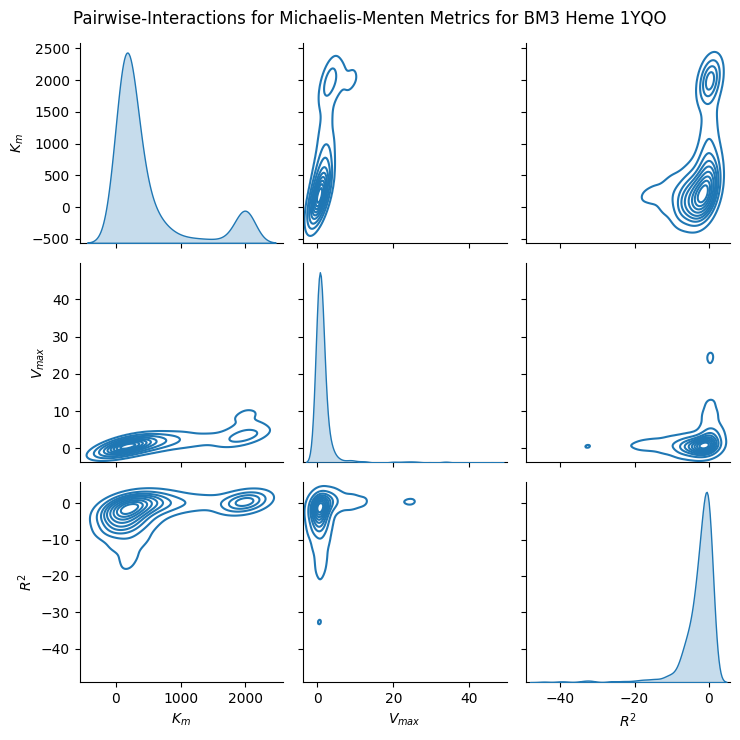

<Figure size 800x800 with 0 Axes>

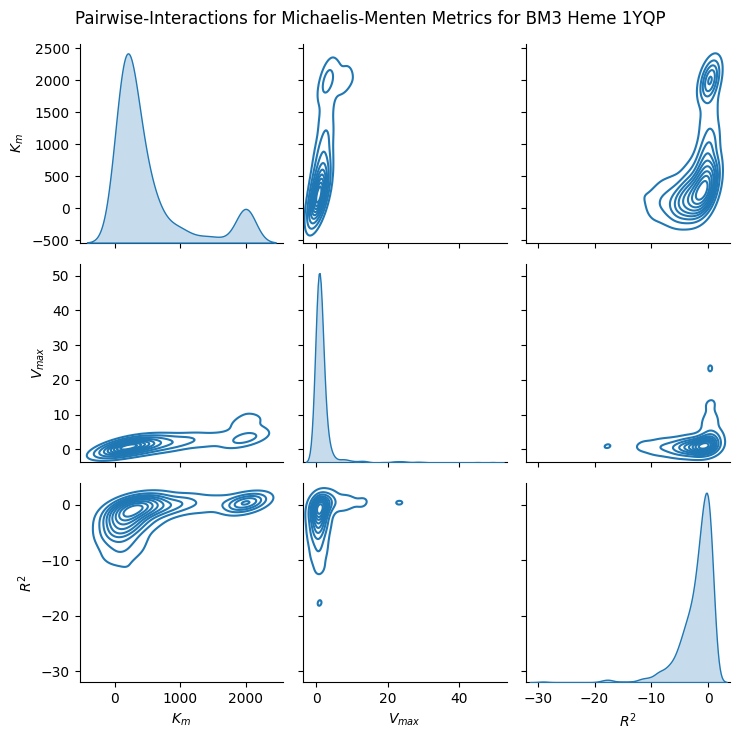

<Figure size 800x800 with 0 Axes>

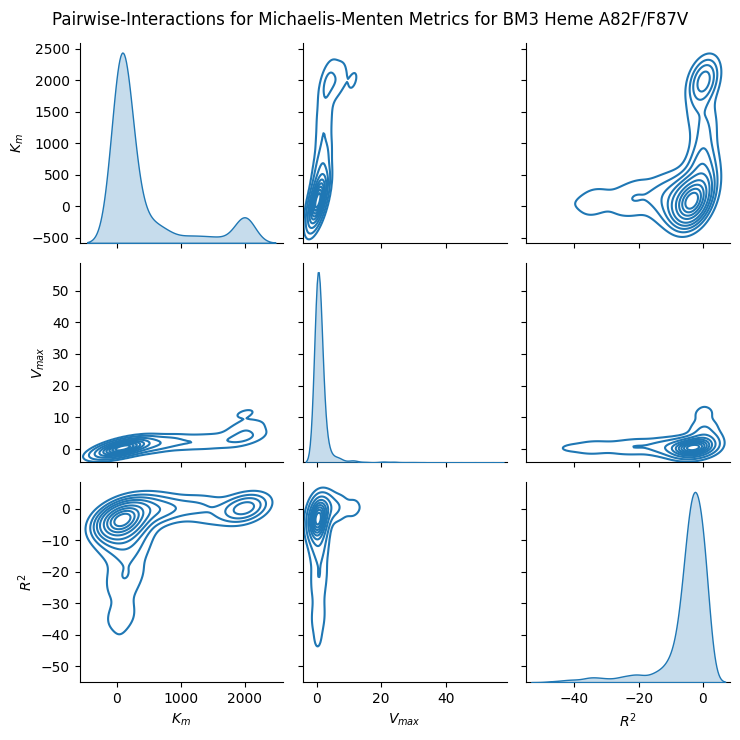

<Figure size 800x800 with 0 Axes>

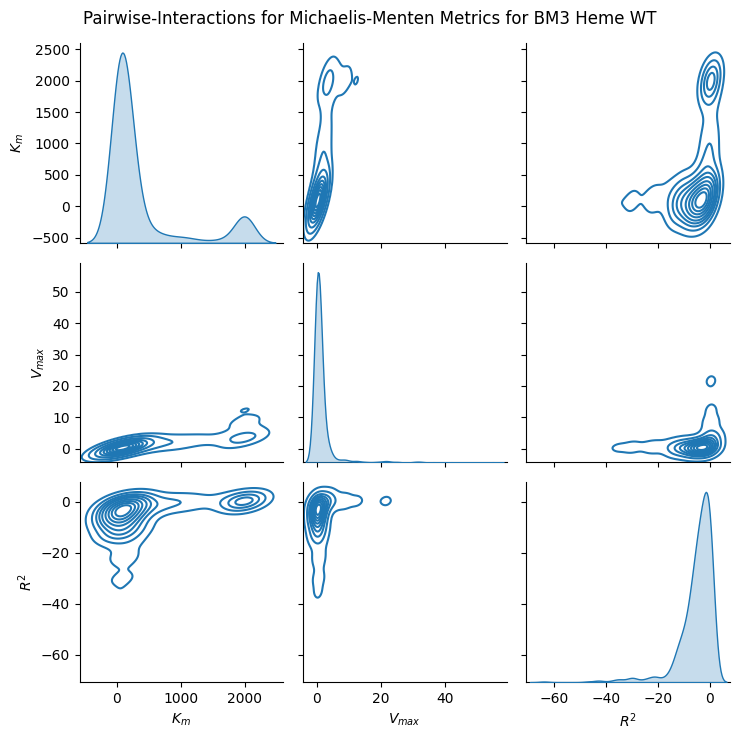

<Figure size 800x800 with 0 Axes>

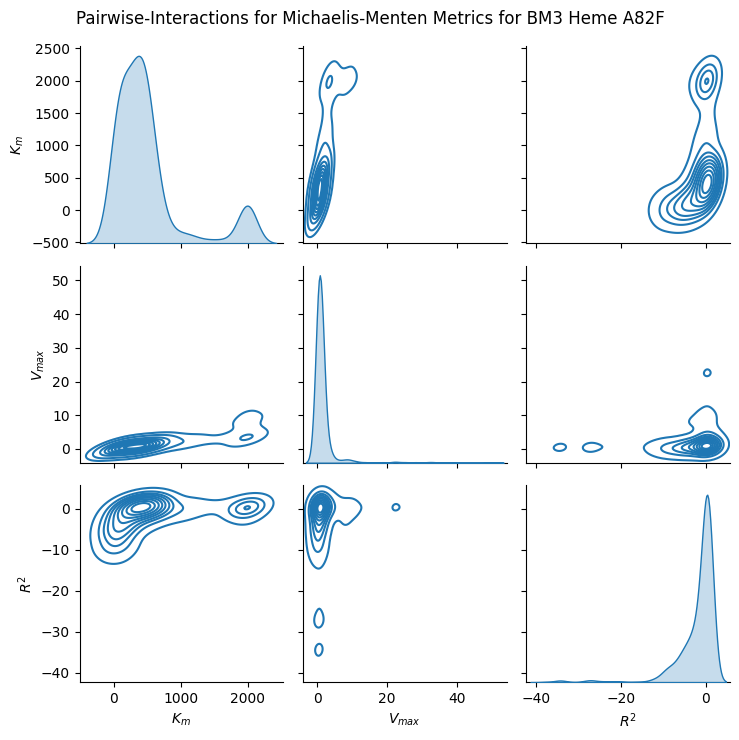

In [11]:
import seaborn as sns
for i in kd_data['protein'].unique():
    chunk = kd_data.loc[kd_data['protein']==i,['km','vmax','rsq']]
    chunk.columns = ['$K_m$', '$V_{max}$', '$R^2$']
    plt.figure(figsize=(8,8))
    sns.pairplot(chunk,
                 kind='kde', )
    plt.suptitle(f'Pairwise-Interactions for Michaelis-Menten Metrics for {i}')
    plt.tight_layout()
    plt.savefig(f"img/{i.replace('/','-').replace(' ','-')}-mm-pairwise.png") 
    plt.show() 

<Figure size 800x800 with 0 Axes>

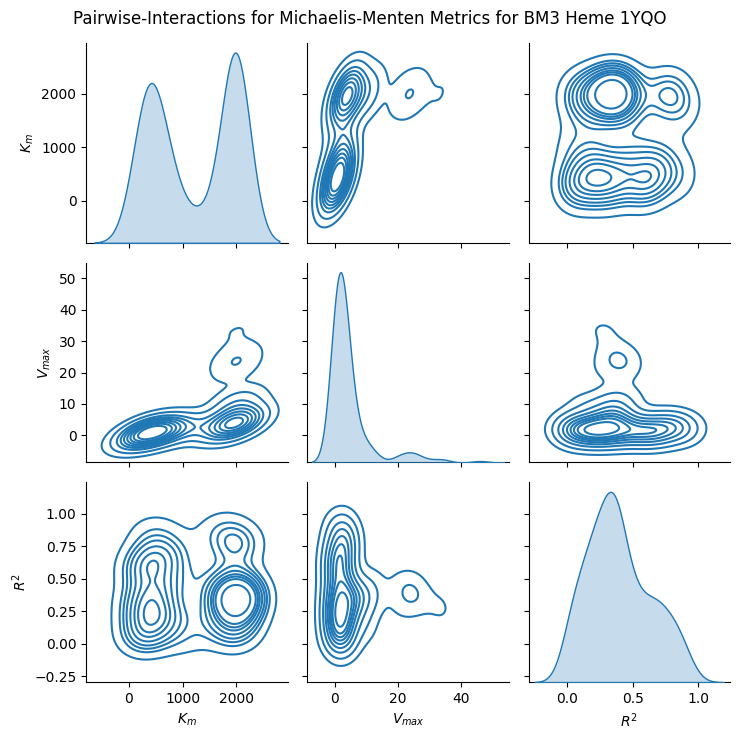

<Figure size 800x800 with 0 Axes>

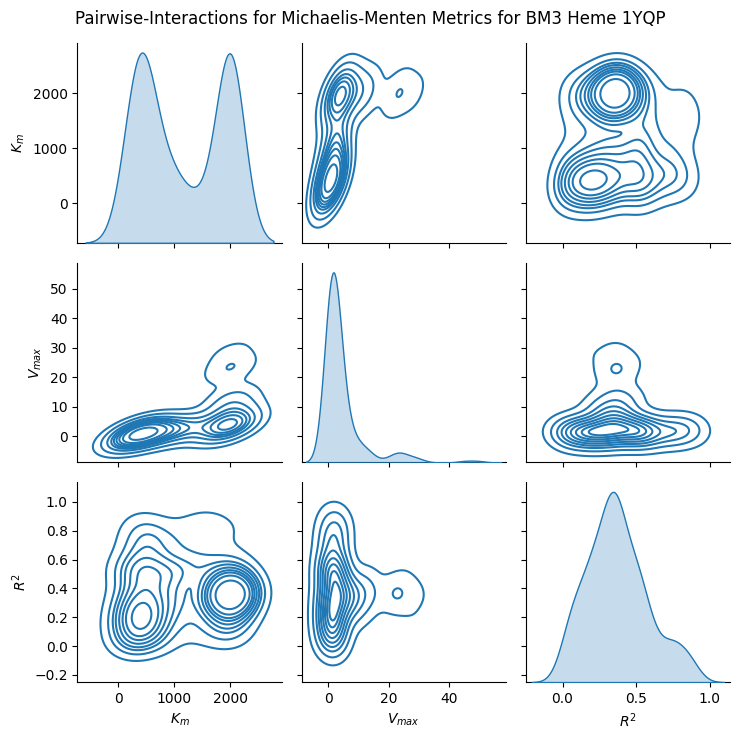

<Figure size 800x800 with 0 Axes>

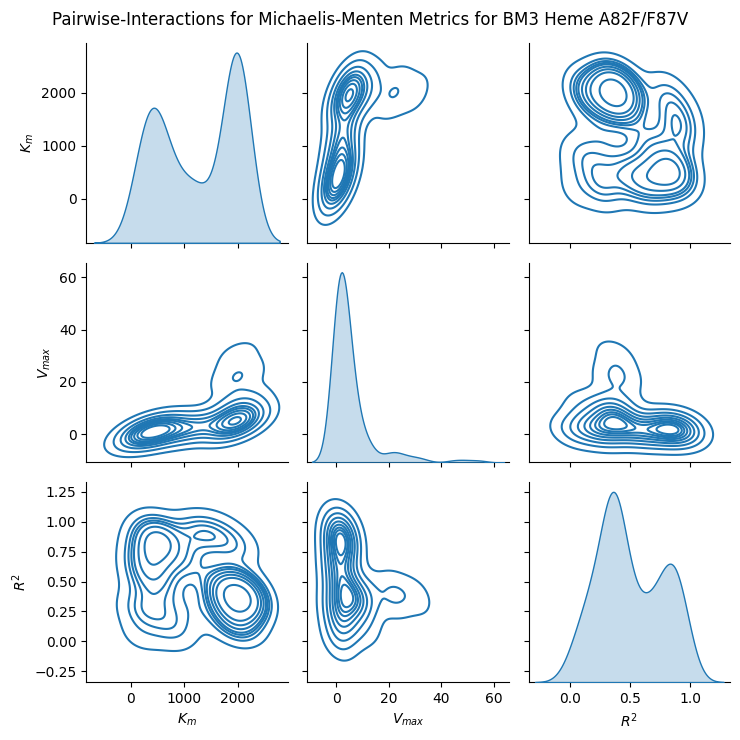

<Figure size 800x800 with 0 Axes>

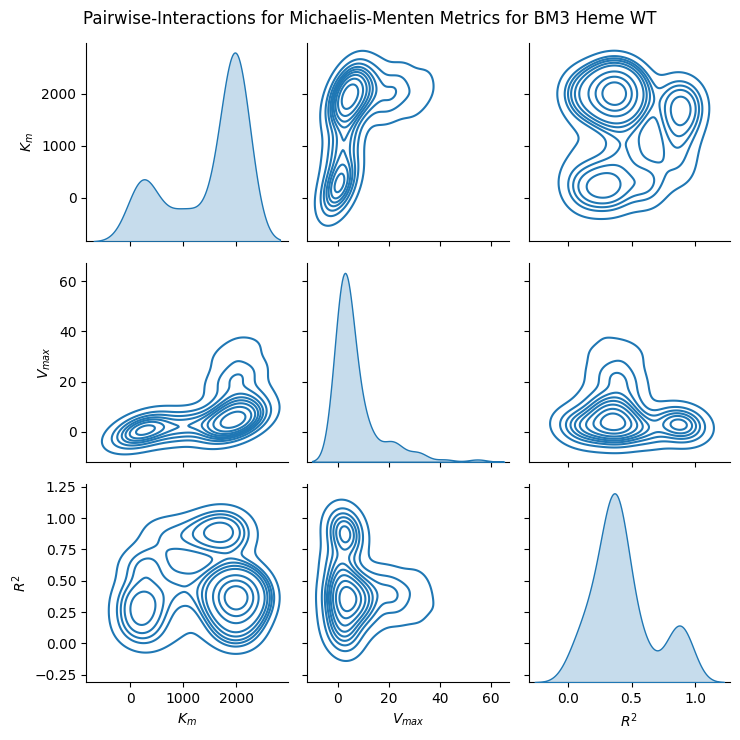

<Figure size 800x800 with 0 Axes>

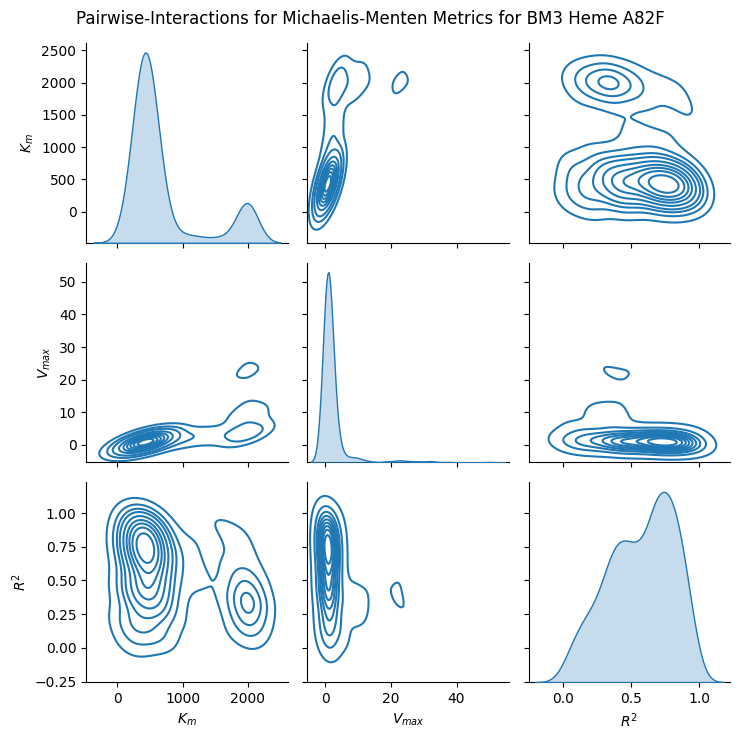

In [12]:
for i in kd_data['protein'].unique():
    chunk = kd_data_.loc[kd_data_['protein']==i,['km','vmax','rsq']]
    chunk.columns = ['$K_m$', '$V_{max}$', '$R^2$']
    plt.figure(figsize=(8,8))
    sns.pairplot(chunk,
                 kind='kde', )
    plt.suptitle(f'Pairwise-Interactions for Michaelis-Menten Metrics for {i}')
    plt.tight_layout()
    plt.savefig(f"img/{i.replace('/','-').replace(' ','-')}-mm-pairwise-rsqgt0.png") 
    plt.show() 

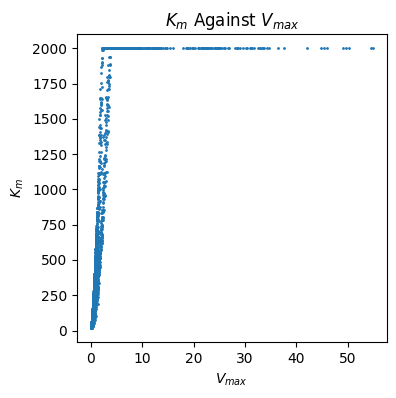

In [13]:
plt.figure(figsize=(4,4))
plt.scatter(kd_data['vmax'],
            kd_data['km'],
            s=1,
           )
plt.xlabel('$V_{max}$')
plt.ylabel('$K_m$')
plt.title('$K_m$ Against $V_{max}$')
plt.show()

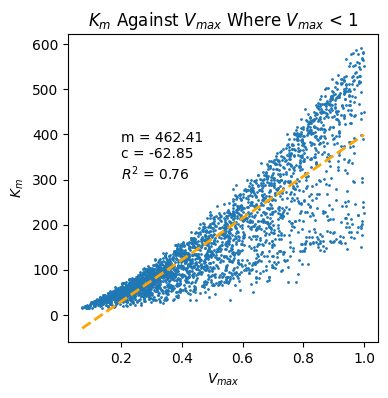

In [14]:
import numpy as np
from scipy.optimize import curve_fit
from sklearn.metrics import r2_score

fn = lambda x, m, c : (m*x) + c


x = kd_data.loc[kd_data['vmax']<1,:]
(m,c), pos = curve_fit(fn, x['vmax'], x['km'])
r2 = r2_score(x['km'], fn(x['vmax'], m, c))
                       
plt.figure(figsize=(4,4))
plt.scatter(x['vmax'],
            x['km'],
            s=1,
           )
x_ = np.linspace(min(x['vmax']),
                 max(x['vmax']),
                 32)
plt.plot(x_, 
        fn(x_,m,c),
        c='orange',
        lw=2,
        linestyle='--',
        )
plt.text(x=0.2,
         y=300,
         s=f'm = {round(m, 3)}\nc = {round(c,3)}\n$R^2$ = {round(r2,2)}'
        )
plt.xlabel('$V_{max}$')
plt.ylabel('$K_m$')
plt.title('$K_m$ Against $V_{max}$ Where $V_{max}$ < 1')
plt.savefig('img/km-vs-vmax-corr.png')
plt.show()

In [15]:
kms = kd_data.loc[kd_data['rsq']>0,:]
kms = kms.loc[kms['vmax']<3,:]

kms['Compond Structure'] = [f'![](img/screen/hits-{i}.png)' for i in kms['cpd']]
kms['Compound Scaffold'] = [f'![](img/screen/hits-{i}-scaffold.png)' for i in kms['cpd']]
kms.columns = [i.capitalize() for i in kms.columns]
kms = kms.loc[kms['Km']<500,:]
print(kms.sort_values('Km').to_markdown(index=False))

| Cpd   | Protein            |      Km |     Vmax |        Rsq | Compond structure              | Compound scaffold                       |
|:------|:-------------------|--------:|---------:|-----------:|:-------------------------------|:----------------------------------------|
| S2057 | BM3 Heme A82F/F87V | 101.444 | 0.272654 | 0.228664   | ![](img/screen/hits-S2057.png) | ![](img/screen/hits-S2057-scaffold.png) |
| S4080 | BM3 Heme A82F      | 131.166 | 0.345483 | 0.281023   | ![](img/screen/hits-S4080.png) | ![](img/screen/hits-S4080-scaffold.png) |
| S2475 | BM3 Heme WT        | 132.316 | 0.346115 | 0.372884   | ![](img/screen/hits-S2475.png) | ![](img/screen/hits-S2475-scaffold.png) |
| S1331 | BM3 Heme A82F/F87V | 133.945 | 0.361724 | 0.017044   | ![](img/screen/hits-S1331.png) | ![](img/screen/hits-S1331-scaffold.png) |
| S2082 | BM3 Heme WT        | 135.067 | 0.372921 | 0.062982   | ![](img/screen/hits-S2082.png) | ![](img/screen/hits-S2082-scaffold.png) |
| S2116 | BM3 Heme W

In [16]:
manual_auto_interestction = sorted(set(hits['chemid']).intersection(set(kms['Cpd'])))
#print(f'overlap between manual and auto hit identification: {len(manual_auto_interestction)} compounds')

In [17]:
len(hits)

149

In [18]:
len(kms)

448

In [19]:
print(lib.shape)
print(xyz.shape)
libxyz = pd.concat([lib, xyz], axis=1) # z is cluster (umap -> dbscan)
libxyz.index = libxyz['CatalogNumber']
libxyz.drop('CatalogNumber', axis=1, inplace=True)
libxyz.head()

(978, 7)
(978, 3)


,Item Name,SMILES,Rack Number,Plate Location,Cluster,Scaffold,x,y,z
CatalogNumber,,,,,,,,,
S1005,Axitinib,CNC(=O)C1=CC=CC=C1SC1=CC2=C(C=C1)C(\C=C\C1=CC=...,L1300-01,a1,0,C(=Cc1n[nH]c2cc(Sc3ccccc3)ccc12)c1ccccn1,6.161997,0.087711,0
S1011,Afatinib (BIBW2992),CN(C)C\C=C\C(=O)NC1=CC2=C(NC3=CC=C(F)C(Cl)=C3)...,L1300-01,b1,1,c1ccc(Nc2ncnc3cc(OC4CCOC4)ccc23)cc1,8.733803,2.061741,1
S1013,Bortezomib (Velcade),CC(C)C[C@H](NC(=O)[C@H](CC1=CC=CC=C1)NC(=O)C1=...,L1300-01,c1,0,O=C(NCCc1ccccc1)c1cnccn1,4.098682,0.537830,0
S1014,Bosutinib (SKI-606),COC1=C(Cl)C=C(Cl)C(NC2=C(C=NC3=CC(OCCCN4CCN(C)...,L1300-01,d1,1,c1ccc(Nc2ccnc3cc(OCCCN4CCNCC4)ccc23)cc1,8.622196,2.004699,1
S1021,Dasatinib (BMS-354825),CC1=NC(NC2=NC=C(S2)C(=O)NC2=C(Cl)C=CC=C2C)=CC(...,L1300-01,e1,0,O=C(Nc1ccccc1)c1cnc(Nc2cc(N3CCNCC3)ncn2)s1,6.390736,1.849801,0


In [20]:
getxyz = lambda cpd : libxyz.loc[cpd, ['x','y','z']]
dfxyz = pd.concat([df, df['chemid'].apply(getxyz)], axis=1)
dfxyz.head()

,experiment,protein,seq,chemid,smiles,hit,x,y,z
0,05.0/,BM3 Heme 1YQO,MTIKEMPQPKTFGELKNLPLLNTDKPVQALMKIADELGEIFKFEAP...,S2581,Cl.CCOC(=O)[C@H](CCC1=CC=CC=C1)N[C@@H](C)C(=O)...,False,4.197132,0.506061,0
1,02.0/,BM3 Heme A82F/F87V,MTIKEMPQPKTFGELKNLPLLNTDKPVQALMKIADELGEIFKFEAP...,S1407,CCNC(=O)CCC\C=C/C[C@H]1[C@@H](O)C[C@H](O)[C@@H...,False,6.134546,-2.516823,0
2,05.0/,BM3 Heme 1YQO,MTIKEMPQPKTFGELKNLPLLNTDKPVQALMKIADELGEIFKFEAP...,S2215,C[C@H](NC(=O)CC1=CC(F)=CC(F)=C1)C(=O)N[C@H](C(...,False,5.668237,0.246377,0
3,02.0/,BM3 Heme A82F/F87V,MTIKEMPQPKTFGELKNLPLLNTDKPVQALMKIADELGEIFKFEAP...,S1229,NC1=NC(F)=NC2=C1N=CN2[C@@H]1O[C@H](COP(O)(O)=O...,False,5.642278,11.536323,4
4,01.0/,BM3 Heme WT,MTIKEMPQPKTFGELKNLPLLNTDKPVQALMKIADELGEIFKFEAP...,S2124,OC[C@@H](O)[C@H](O)[C@@H](O)C=O |r|,False,5.598822,-2.907768,0


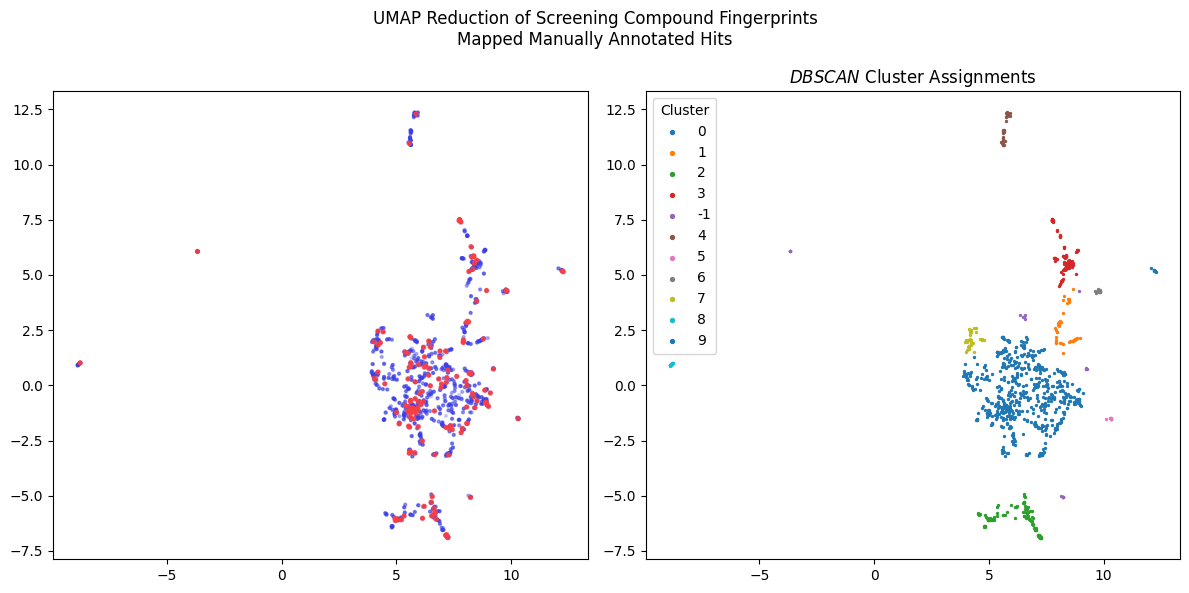

In [21]:
colours = {True: '#ff3f3f', False:'#3b3fe7'}

size = lambda hit : 8 if hit else 4
alpha = lambda hit : 0.8 if hit else 0.2

fig, ax = plt.subplots(1,2, figsize=(12,6))
for i, j in zip([False, True, ],
                ['Miss','Hit',],
               ):
    dfxyz_ = dfxyz.loc[dfxyz['hit']==i,:]
    ax[0].scatter(dfxyz_['x'],
                dfxyz_['y'],
                c=colours[i],
                s=dfxyz_['hit'].apply(size),
                alpha=dfxyz_['hit'].apply(alpha),
                #alpha=0.2,
                label=j,
               )
    
for i in xyz['z'].unique():
    cl = xyz.loc[xyz['z'] == i, :]
    ax[1].scatter(cl['x'], 
              cl['y'],
              s=2,
              label=i,
             )
ax[1].set_title('$DBSCAN$ Cluster Assignments')
ax[1].legend(markerscale=2,
               loc='best',
              title='Cluster',
              )

fig.suptitle('UMAP Reduction of Screening Compound Fingerprints\nMapped Manually Annotated Hits')
plt.tight_layout()
plt.savefig('img/cpd-umap-man.png')
plt.show()

In [22]:
kmxyz = pd.concat([kms,kms['Cpd'].apply(getxyz)], axis=1)
kmxyz

,Cpd,Protein,Km,Vmax,Rsq,Compond structure,Compound scaffold,x,y,z
39,S1178,BM3 Heme 1YQO,414.361612,0.843412,0.603845,![](img/screen/hits-S1178.png),![](img/screen/hits-S1178-scaffold.png),6.082015,1.094611,0
103,S3188,BM3 Heme 1YQO,329.801432,0.790060,0.242186,![](img/screen/hits-S3188.png),![](img/screen/hits-S3188-scaffold.png),8.545050,-0.511560,0
128,S4038,BM3 Heme 1YQO,321.058645,0.719845,0.380549,![](img/screen/hits-S4038.png),![](img/screen/hits-S4038-scaffold.png),7.874578,2.614721,1
155,S4089,BM3 Heme 1YQO,414.098772,0.810509,0.687149,![](img/screen/hits-S4089.png),![](img/screen/hits-S4089-scaffold.png),7.219162,-6.901062,2
163,S4049,BM3 Heme 1YQO,266.035516,0.625044,0.556953,![](img/screen/hits-S4049.png),![](img/screen/hits-S4049-scaffold.png),4.160859,2.271647,7
...,...,...,...,...,...,...,...,...,...,...
4102,S2533,BM3 Heme A82F,461.232248,0.844700,0.674404,![](img/screen/hits-S2533.png),![](img/screen/hits-S2533-scaffold.png),8.931633,-0.818548,0
4103,S2537,BM3 Heme A82F,141.404936,0.375996,0.168455,![](img/screen/hits-S2537.png),![](img/screen/hits-S2537-scaffold.png),4.449700,-1.565292,0
4104,S2543,BM3 Heme A82F,397.041983,0.868009,0.781110,![](img/screen/hits-S2543.png),![](img/screen/hits-S2543-scaffold.png),8.095825,6.763775,3
4105,S2550,BM3 Heme A82F,422.414069,0.936013,0.189017,![](img/screen/hits-S2550.png),![](img/screen/hits-S2550-scaffold.png),8.251382,-0.627275,0


<Figure size 640x480 with 0 Axes>

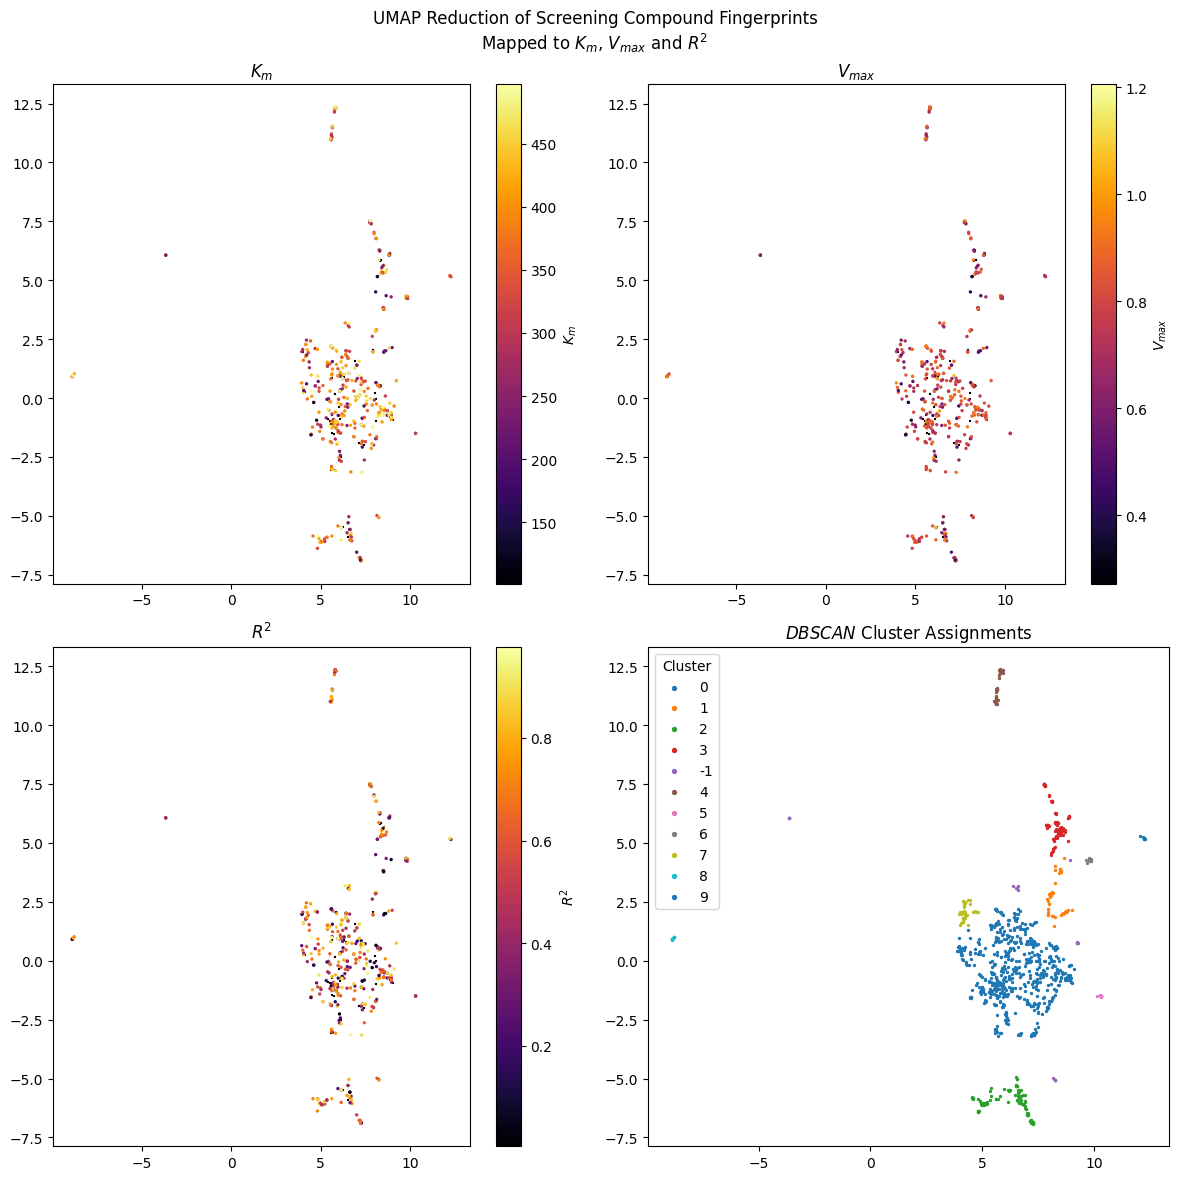

In [23]:
kmxyz = pd.concat([kms,kms['Cpd'].apply(getxyz)], axis=1)

plt.set_cmap('inferno')

fig, ax = plt.subplots(2,2,figsize=(12,12))

for i,j,k in zip(ax.flatten(), 
                 ['Km','Vmax','Rsq'], 
                 ['$K_m$', '$V_{max}$', '$R^2$']):
    i.scatter(dfxyz_['x'],
              dfxyz_['y'],
              c='black',
              s=3,
              marker='+',
              #alpha=0.2,
              #label='Library Compound',
             )

    kmsct = i.scatter(kmxyz['x'],
                      kmxyz['y'],
                      c=kmxyz[j],
                      s=2,
                      )

    _cb = fig.colorbar(kmsct, label=k, ax=i)
    i.set_title(f'{k}')
    

for i in xyz['z'].unique():
    cl = xyz.loc[xyz['z'] == i, :]
    ax[1,1].scatter(cl['x'], 
                cl['y'],
                s=2,
                label=i,
               )
ax[1,1].set_title('$DBSCAN$ Cluster Assignments')
ax[1,1].legend(markerscale=2,
               loc='best',
              title='Cluster',
              )

fig.suptitle('UMAP Reduction of Screening Compound Fingerprints\nMapped to $K_m$, $V_{max}$ and $R^2$')
plt.tight_layout()
plt.savefig('img/cpd-umap-kms.png')
plt.show()

{'BM3 Heme 1YQO': 1, 'BM3 Heme 1YQP': 1, 'BM3 Heme A82F': 147, 'BM3 Heme A82F/F87V': 0, 'BM3 Heme WT': 0}


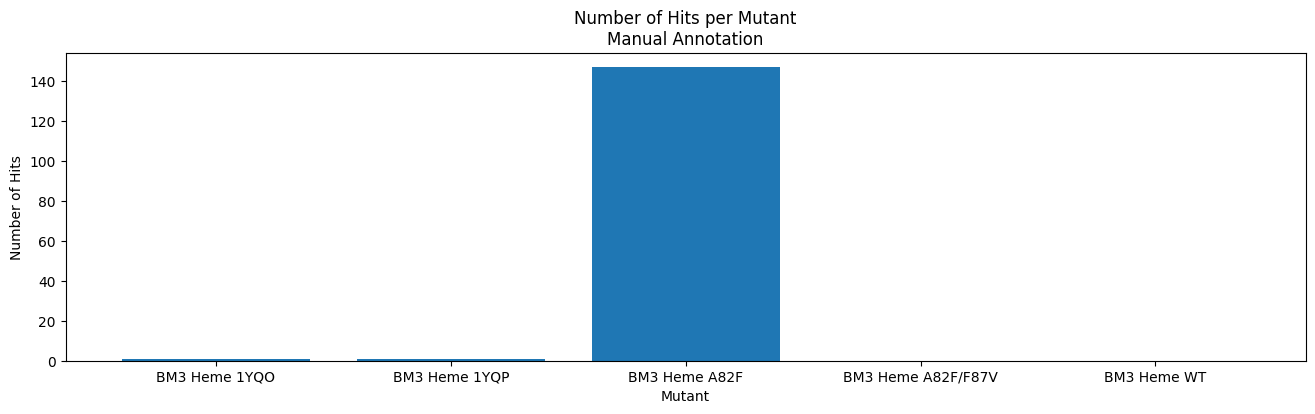

In [24]:
_d = {i:sum(df.loc[df['protein']==i,'hit']) for i in df['protein'].unique()}
_d = {i:_d[i] for i in sorted(_d)}
print(_d)
plt.figure(figsize=(16,4))
plt.bar(_d.keys(), _d.values())
plt.ylabel('Number of Hits')
plt.xlabel('Mutant')
plt.title('Number of Hits per Mutant\nManual Annotation')
plt.savefig('img/hits-hist-man.png')
plt.show()

In [25]:
print(pd.Series(_d, name='Number of Hits').to_markdown())

|                    |   Number of Hits |
|:-------------------|-----------------:|
| BM3 Heme 1YQO      |                1 |
| BM3 Heme 1YQP      |                1 |
| BM3 Heme A82F      |              147 |
| BM3 Heme A82F/F87V |                0 |
| BM3 Heme WT        |                0 |


In [26]:
_dk = kms['Protein'].value_counts().sort_index()
print(_dk.to_markdown())

|                    |   Protein |
|:-------------------|----------:|
| BM3 Heme 1YQO      |        54 |
| BM3 Heme 1YQP      |        61 |
| BM3 Heme A82F      |       267 |
| BM3 Heme A82F/F87V |        40 |
| BM3 Heme WT        |        26 |


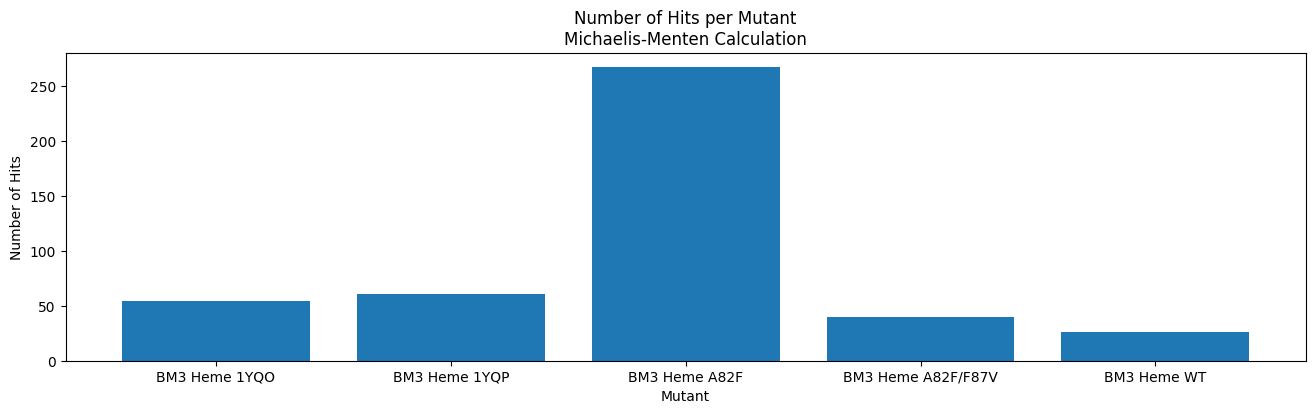

In [27]:
plt.figure(figsize=(16,4))
plt.bar(_dk.index, _dk)
plt.ylabel('Number of Hits')
plt.xlabel('Mutant')
plt.title('Number of Hits per Mutant\nMichaelis-Menten Calculation')
plt.savefig('img/hits-hist-km.png')
plt.show()

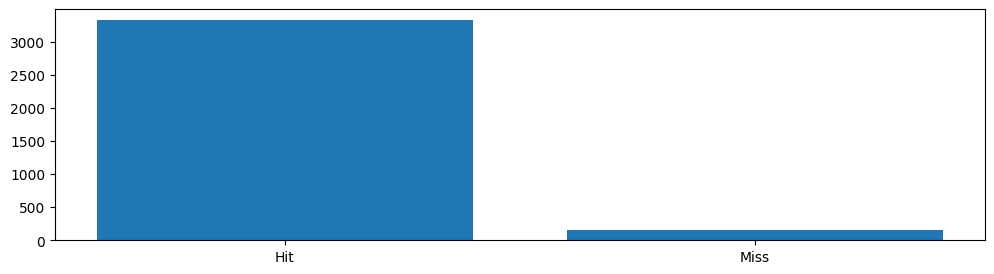

In [28]:
cpd_fp = lambda cpd_no : fps[lib['CatalogNumber']==cpd_no]

x = np.vstack(list(map(cpd_fp, df['chemid'])))
y = df['hit']

yvc = y.value_counts()
plt.figure(figsize=(12,3))
plt.bar(yvc.index,
        yvc)
plt.xticks([0,1],['Hit','Miss'])
plt.show()

In [29]:
%%time 
from sklearn.ensemble import RandomForestClassifier 
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

x1 = x[y]
y1 = y[y]

ft_importances = []
evals = []
for _ in tqdm(range(64)):
    model = RandomForestClassifier(n_jobs=-1)
    y0 = y[y==False].sample(len(y1))
    x0 = x[y0.index]
    _x = np.concatenate([x0, x1])
    _y = np.concatenate([y0, y1])

    _xtrn, _xtst, _ytrn, _ytst = train_test_split(_x, _y)

    _yh = model.fit(_xtrn, _ytrn)
    _yh = model.predict(_xtst)
    _eval = {'accuracy':accuracy_score(_yh, _ytst)}
    evals.append(_eval)
    ft_importances.append(model.feature_importances_)
    
ft_importances = np.stack(ft_importances)
evals = pd.DataFrame(evals)
evals

100%|████████████████████████████████████████████████████████████████████████████████| 64/64 [00:29<00:00,  2.14it/s]

CPU times: user 28.5 s, sys: 3.94 s, total: 32.4 s
Wall time: 29.9 s


,accuracy
0,0.440000
1,0.466667
2,0.360000
3,0.466667
4,0.546667
...,...
59,0.440000
60,0.533333
61,0.413333
62,0.413333


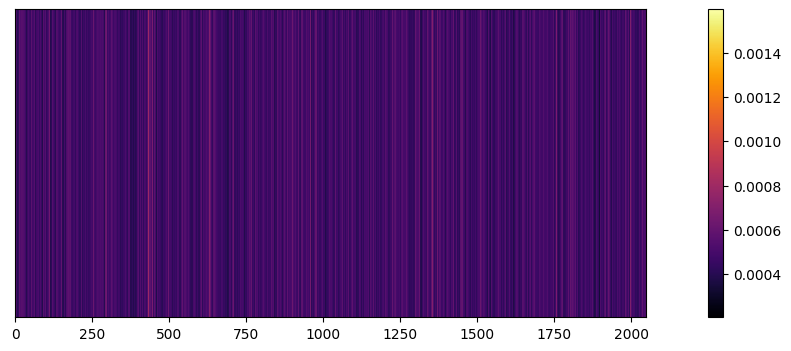

In [30]:
plt.figure(figsize=(16,4))
plt.imshow(ft_importances.mean(axis=0).reshape(1,-1), aspect=1e3)
plt.yticks([])
plt.colorbar()
plt.show()

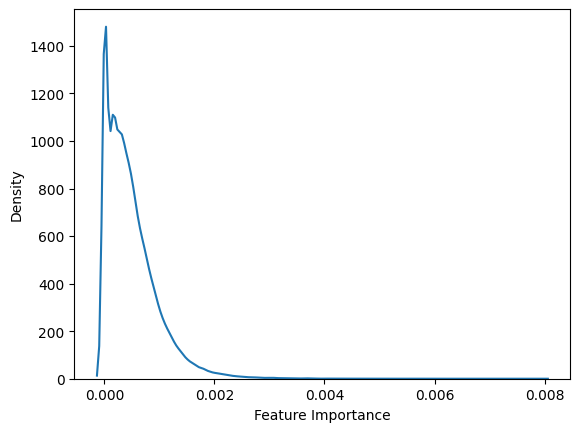

In [31]:
sns.kdeplot(ft_importances.flatten())
plt.xlabel('Feature Importance')
plt.show()

In [32]:
len(props)

NameError: name 'props' is not defined

In [ ]:
from pprint import pprint
from rdkit.Chem import Crippen 

_lib = lib.copy()
_lib.index = _lib['CatalogNumber']

_lib_mols = list(map(Chem.AddHs, map(Chem.MolFromSmiles, _lib['SMILES'])))

feature_fns = [
        'CalcLabuteASA', 'CalcTPSA', 'CalcExactMolWt',
        'CalcNumLipinskiHBD', 'CalcNumLipinskiHBA', 'CalcNumHBD', 'CalcNumHBA',
        'CalcNumRotatableBonds', 'CalcNumRings', 'CalcNumAromaticRings',
        'CalcNumSaturatedRings', 'CalcNumHeterocycles', 'CalcNumAromaticHeterocycles',
        'CalcNumAromaticCarbocycles', 'CalcNumSaturatedHeterocycles',
        'CalcNumSaturatedCarbocycles', 'CalcNumAliphaticRings',
        'CalcNumAliphaticHeterocycles', 'CalcNumAliphaticCarbocycles', 'CalcNumHeteroatoms',
        'CalcNumAmideBonds', 'CalcFractionCSP3', 'CalcChi0v', 'CalcChi1v', 'CalcChi2v', 'CalcChi3v',
        'CalcChi4v', 'CalcChi0n', 'CalcChi1n', 'CalcChi2n', 'CalcChi3n', 'CalcChi4n', 'CalcHallKierAlpha',
        'CalcKappa1', 'CalcKappa2', 'CalcKappa3', 'CalcNumSpiroAtoms', 'CalcNumBridgeheadAtoms',
        'MolLogP'
        ]

feature_fns =  [i for i in feature_fns if i in Chem.__dict__ or i in Crippen.__dict__]

_fn = lambda mol, fn_name : Chem.__dict__[fn_name](mol) if fn_name in Chem.__dict__ else Crippen.__dict__[fn_name](mol)
fn = lambda mol : {fn_name.replace('Calc',''):_fn(mol, fn_name) for fn_name in feature_fns} 

_props = {}
assert len(_lib_mols) == len(_lib['CatalogNumber'])
for m,n in tqdm(zip(_lib_mols, 
                    _lib['CatalogNumber']),
                total=len(_lib_mols),
               ):
    _props[n] = fn(m)
props = pd.DataFrame(_props).T
props.head()

In [ ]:
len(props)

In [ ]:
fig, ax = plt.subplots(len(props.columns)//4,
                       4,
                       figsize=(12, 24))
for i,j in tqdm(zip(props.columns, 
                    ax.flatten()), 
                total=len(propsxcolumns)):
    j.hist(props[i], )
    j.set_title(i)
    j.set_xlabel(i)
ax[-1,-1].axis('off')
plt.tight_layout()
plt.show()

In [ ]:
%%time
from sklearn.preprocessing import RobustScaler

um_ = UMAP(n_neighbors=16,
           n_components=2,
           metric='euclidean',
           min_dist=1/8,
           output_metric='euclidean',
           n_epochs=2048,
           learning_rate=1/4,
           n_jobs=-1,
           verbose=True,
        )

rsclr = RobustScaler()
nprops = pd.DataFrame(rsclr.fit_transform(props),
                      columns=props.columns,
                      index=props.index,
                      )

npropsxy = pd.DataFrame(um_.fit_transform(nprops),
                        columns=['x','y'],
                        index=nprops.index,
                       )
getxyz_ = lambda cpd : npropsxy.loc[cpd, ['x','y']]
propsxyz_km = pd.concat([kms,kms['Cpd'].apply(getxyz_)], axis=1)

dbscan_ = DBSCAN(eps=1)
clusters_ = dbscan_.fit_predict(propsxyz_km[list('xy')])
propsxyz_km['Cluster'] = clusters_
propsxyz_km['Cluster'] = clusters_


fig, ax = plt.subplots(2,2,figsize=(12,12))

for i,j,k in zip(ax.flatten(), 
                 ['Km','Vmax','Rsq'], 
                 ['$K_m$', '$V_{max}$', '$R^2$']):
    i.scatter(propsxyz_km['x'],
              propsxyz_km['y'],
              c='black',
              s=5,
              marker='+',
              #alpha=0.2,
              #label='Library Compound',
             )

    kmsct =i.scatter(propsxyz_km['x'],
                     propsxyz_km['y'],
                     c=propsxyz_km[j],
                     s=5,
                     )

    _cb = fig.colorbar(kmsct, label=k, ax=i)
    i.set_title(f'{k}')
    

for i in propsxyz_km['Cluster'].unique():
    cl = propsxyz_km.loc[propsxyz_km['Cluster'] == i, :]
    ax[1,1].scatter(cl['x'], 
                cl['y'],
                s=8,
                label=i,
               )
ax[1,1].set_title('$DBSCAN$ Cluster Assignments')
ax[1,1].legend(markerscale=2,
               loc='best',
              title='Cluster',
              )

fig.suptitle('UMAP Reduction of Screening Compound Properties\nMapped to $K_m$, $V_{max}$ and $R^2$')
plt.tight_layout()
plt.savefig('img/cpd-umap-props-kms.png')
plt.show()

In [ ]:
#propsxyz_km['Cluster'] = clusters_
#props['Cluster'] = clusters_
propsxyz_km = pd.concat([kms,kms['Cpd'].apply(getxyz_)], axis=1)
propsxyz_km

In [ ]:
fig, ax = plt.subplots(len(props.columns)//4,
                       4,
                       figsize=(12, 24))
propsxyz_km['Cluster'] = clusters_
for i,j in tqdm(zip(props.columns, 
                    ax.flatten()), 
                total=len(props.columns)):
    for _clus in propsxyz_km['Cluster'].unique():
        clus = propsxyz_km.loc[propsxyz_km['Cluster']==_clus, :]
        sns.kdeplot(clus[i], 
                    label=i,
                    ax=j,
                    alpha=0.5)
    j.set_title(i)
    j.set_xlabel(i)
    
ax[-1,-1].axis('off')
plt.tight_layout()
plt.show()

In [ ]:
xyz_prop = um.fit_transform(props.

In [ ]:
fn(lib_mols[0])

In [ ]:
Crippen.MolLogP
Crippen.